# 🧠 Task 3 – Correlation Between News Sentiment and Stock Price Movement  
📘 Version: 2025-06-04  

This notebook initiates the third and final analytical phase of the challenge, focused on uncovering statistical relationships between sentiment signals and market behavior.  
It leverages enriched datasets from previous tasks to explore correlations between news-driven sentiment and subsequent stock price returns.

---

### 📌 This notebook covers:
- 🧽 Aggregation of sentiment signals by ticker and date (using `correlation_sentiment_aggregator.py`)  
- 📉 Calculation of daily and forward returns from OHLCV data  
- 🔍 Correlation diagnostics between sentiment scores and returns across multiple windows  
- 📊 Visualization of sentiment-return relationships with heatmaps, scatter plots, and line charts (`correlation_visualizer.py`)  
- 🧠 Statistical insight generation to identify predictive patterns and anomalies  
- 💾 Outputs clean correlation-ready datasets and summary metrics for final reporting


In [1]:
# 🗂️ Project Directory Setup

#To ensure smooth path handling across environments, we standardize the working directory and define data locations relative to the project root.

#- **Sentiment Dataset**: `data/cleaned_headlines_sample.csv`
#- **Stock Price Data**: `data/yfinance_data/*.csv`

#All modules are assumed to be accessible from the `src/` folder when running the notebook from the root.

# 🛠 Standardize working directory
import os

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
print("📂 Working directory is now:", os.getcwd())

# 🔎 Confirm required sentiment and price files exist
sentiment_file = "data/cleaned_headlines_sample.csv"
price_dir = "data/yfinance_data"
expected_tickers = ["AAPL", "AMZN", "GOOG", "META", "MSFT", "NVDA", "TSLA"]

# Check sentiment file
print("📄 Sentiment file found ✅" if os.path.exists(sentiment_file) else f"❌ Sentiment file missing: {sentiment_file}")

# Check stock price files
for ticker in expected_tickers:
    price_path = os.path.join(price_dir, f"{ticker}_historical_data.csv")
    status = "✅" if os.path.exists(price_path) else "❌"
    print(f"{status} {ticker} data file: {price_path}")


📂 Working directory is now: c:\Users\admin\Documents\GIT Repositories\b5w1-stock-market-challenge
📄 Sentiment file found ✅
✅ AAPL data file: data/yfinance_data\AAPL_historical_data.csv
✅ AMZN data file: data/yfinance_data\AMZN_historical_data.csv
✅ GOOG data file: data/yfinance_data\GOOG_historical_data.csv
✅ META data file: data/yfinance_data\META_historical_data.csv
✅ MSFT data file: data/yfinance_data\MSFT_historical_data.csv
✅ NVDA data file: data/yfinance_data\NVDA_historical_data.csv
✅ TSLA data file: data/yfinance_data\TSLA_historical_data.csv


In [2]:
# ----------------------------------------------------------------------
# 📦 Core Libraries for Correlation & Data Analysis
# ----------------------------------------------------------------------
import os  # Filepath control
import sys  # Runtime path access for module imports
import pandas as pd  # DataFrame manipulation
import numpy as np  # Numerical ops for correlation and returns
import matplotlib.pyplot as plt  # Plotting backend
import seaborn as sns  # Styled plots

# ----------------------------------------------------------------------
# 🧠 Statistical and Sentiment Libraries
# ----------------------------------------------------------------------
from scipy.stats import pearsonr, spearmanr, kendalltau  # Correlation metrics
from textblob import TextBlob  # For optional fallback sentiment analysis
from nltk.sentiment import SentimentIntensityAnalyzer  # For NLTK VADER

# ----------------------------------------------------------------------
# 📈 Technical Indicator Support (Legacy from Task 2, Optional)
# ----------------------------------------------------------------------
import talib  # If technical indicator overlays still needed

# ----------------------------------------------------------------------
# 🔁 Dev Utilities
# ----------------------------------------------------------------------
import importlib  # Live reloads while iterating
from IPython.display import display  # For pretty DataFrame rendering

# ----------------------------------------------------------------------
# 🧪 Reload Project Modules (Task 3 Variants)
# ----------------------------------------------------------------------
import src.correlation_sentiment_aggregator
import src.correlation_analyzer
import src.correlation_visualizer
import src.price_data_loader
import src.news_loader
import src.correlation_data_loader

importlib.reload(src.correlation_sentiment_aggregator)
importlib.reload(src.correlation_analyzer)
importlib.reload(src.correlation_visualizer)
importlib.reload(src.price_data_loader)
importlib.reload(src.news_loader)

from src.correlation_data_loader import CorrelationDataLoader
from src.correlation_sentiment_aggregator import CorrelationSentimentAggregator
from src.correlation_analyzer import CorrelationAnalyzer
from src.correlation_visualizer import CorrelationVisualizer
from src.price_data_loader import PriceDataLoader
from src.news_loader import NewsDataLoader


# ----------------------------------------------------------------------
# 📋 Display Config
# ----------------------------------------------------------------------
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)
sns.set(style="whitegrid")  # Consistent plot style

In [3]:
# ------------------------------------------------------------------------------
# 📥 Load Aligned Sentiment–Price Dataset & Full Enriched News Data (Task 3)
# ------------------------------------------------------------------------------

# Import the custom Task 3 loader
from src.correlation_data_loader import CorrelationDataLoader

# Define file paths for pre-aligned and full enriched datasets
ALIGNED_PATH = "data/outputs/enriched_aligned_df.csv"
FULL_PATH = "data/outputs/enriched_full_df.csv"

# Initialize the loader with both paths
try:
    correlation_loader = CorrelationDataLoader(
        full_path=FULL_PATH, aligned_path=ALIGNED_PATH, verbose=True
    )

    # Load both datasets
    aligned_df = correlation_loader.load_aligned_df()
    full_df = correlation_loader.load_full_df()

    print("✅ Both enriched datasets loaded successfully for correlation analysis.")
except Exception as e:
    print(f"❌ Failed to load correlation datasets: {e}")
    aligned_df = None
    full_df = None


📄 Loaded enriched_aligned_df from data/outputs/enriched_aligned_df.csv
🔢 Shape: 1,786 rows × 39 columns
🗓️ Date range: 2011-03-07 → 2020-06-09
🧪 Null values:
forward_return_5d    20
forward_return_3d    10
Date_x                0
Low_x                 0
Close_x               0
Open_x                0
High_x                0
Volume_x              0
Adj Close_x           0
cleaned_date          0
dtype: int64


📄 Loaded enriched_full_df from data/outputs/enriched_full_df.csv
🔢 Shape: 45,428 rows × 21 columns
🗓️ Date range: 1980-12-12 → 2024-07-30
🧪 Null values:
MACD_signal    231
MACD           231
ATR_14          98
RSI_14          98
SMA_14          91
EMA_14          91
Close            0
High             0
Open             0
Date_x           0
dtype: int64

✅ Both enriched datasets loaded successfully for correlation analysis.


## ✅ Initial Sanity Checks – Structure, Missingness, Duplicates

Before diving into analysis, we run a quick diagnostic to verify data health:

- Preview the top 3 rows for structural validation.
- Print full column data types to confirm schema expectations.
- Check for missing values across all columns.
- Identify and count any fully duplicated rows.

These checks help detect formatting issues or corrupt entries early, ensuring downstream feature engineering operates on clean and consistent data.


In [4]:
# ------------------------------------------------------------------------------
# ✅ Initial Sanity Check – Aligned & Full Enriched Datasets (Task 3)
# ------------------------------------------------------------------------------


def run_sanity_check(df, name="DataFrame"):
    """
    Runs basic data quality checks on a given DataFrame.

    Parameters:
    -----------
    df : pd.DataFrame
        The DataFrame to check.
    name : str
        A label for the dataset (used in printouts).
    """
    print(f"\n🧪 Sanity Check – {name}")
    print("-" * 60)

    if df is not None:
        # Show top rows
        display(df.head(3))

        # Column types
        print("🧬 Column Data Types:")
        print(df.dtypes)

        # Null summary
        print("\n🔍 Missing Value Summary:")
        missing = df.isna().sum()
        print(
            missing[missing > 0] if missing.any() else "✅ No missing values detected."
        )

        # Duplicates
        dupes = df.duplicated().sum()
        print(
            f"⚠️ Found {dupes:,} duplicate rows."
            if dupes > 0
            else "✅ No duplicate rows found."
        )
    else:
        print(f"🚫 Skipping {name} – DataFrame not loaded.")


# Run sanity checks on Task 3 datasets
run_sanity_check(aligned_df, name="🧠 Aligned Sentiment–Price Data")
run_sanity_check(full_df, name="📊 Full Enriched Price History")


🧪 Sanity Check – 🧠 Aligned Sentiment–Price Data
------------------------------------------------------------


,Date_x,Open_x,High_x,Low_x,Close_x,Adj Close_x,Volume_x,Dividends_x,Stock Splits_x,cleaned_date,ticker,weighted_sentiment,return_t,forward_return_1d,forward_return_3d,forward_return_5d,volume_return_t,volume_7d_avg,volume_spike,sentiment_volume_divergence,Date_y,Open_y,High_y,Low_y,Close_y,Adj Close_y,Volume_y,Dividends_y,Stock Splits_y,SMA_14,EMA_14,RSI_14,MACD,MACD_signal,ATR_14,annualized_return,annualized_volatility,sharpe_ratio,max_drawdown
0,2020-03-10,69.285004,71.610001,67.342499,71.334999,69.398438,285290000,0.0,0.0,2020-03-10,AAPL,0.125000,0.072022,-0.034731,-0.025829,-0.113829,-0.005074,2.860174e+08,0,bullish_low_vol,2020-03-10,69.285004,71.610001,67.342499,71.334999,69.398438,285290000,0.0,0.0,72.919106,73.067838,44.605440,-1.955133,-1.371635,3.439214,0.185899,0.442794,0.419833,-0.822166
1,2020-03-11,69.347504,70.305000,67.964996,68.857498,66.988190,255598800,0.0,0.0,2020-03-11,AAPL,0.285714,-0.034731,-0.098755,-0.120611,-0.104419,-0.104074,2.758779e+08,0,bullish_low_vol,2020-03-11,69.347504,70.305000,67.964996,68.857498,66.988190,255598800,0.0,0.0,72.117856,72.506459,41.294936,-2.113048,-1.519917,3.434270,0.185899,0.442794,0.419833,-0.822166
2,2020-03-12,63.985001,67.500000,62.000000,62.057499,60.372791,418474000,0.0,0.0,2020-03-12,AAPL,0.000000,-0.098755,0.119808,0.018652,-0.013898,0.637230,3.115269e+08,0,aligned,2020-03-12,63.985001,67.500000,62.000000,62.057499,60.372791,418474000,0.0,0.0,70.960356,71.113264,33.865673,-2.755140,-1.766962,3.678786,0.185899,0.442794,0.419833,-0.822166


🧬 Column Data Types:
Date_x                                 object
Open_x                                float64
High_x                                float64
Low_x                                 float64
Close_x                               float64
Adj Close_x                           float64
Volume_x                                int64
Dividends_x                           float64
Stock Splits_x                        float64
cleaned_date                   datetime64[ns]
ticker                                 object
weighted_sentiment                    float64
return_t                              float64
forward_return_1d                     float64
forward_return_3d                     float64
forward_return_5d                     float64
volume_return_t                       float64
volume_7d_avg                         float64
volume_spike                            int64
sentiment_volume_divergence            object
Date_y                                 object
Open_y       

,Date_x,Open,High,Low,Close,Adj Close_x,Volume,Dividends,Stock Splits,cleaned_date,ticker,SMA_14,EMA_14,RSI_14,MACD,MACD_signal,ATR_14,annualized_return,annualized_volatility,sharpe_ratio,max_drawdown
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.098943,469033600,0.0,0.0,1980-12-12,AAPL,NaN,NaN,NaN,NaN,NaN,NaN,0.185899,0.442794,0.419833,-0.822166
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.093781,175884800,0.0,0.0,1980-12-15,AAPL,NaN,NaN,NaN,NaN,NaN,NaN,0.185899,0.442794,0.419833,-0.822166
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.086898,105728000,0.0,0.0,1980-12-16,AAPL,NaN,NaN,NaN,NaN,NaN,NaN,0.185899,0.442794,0.419833,-0.822166


🧬 Column Data Types:
Date_x                           object
Open                            float64
High                            float64
Low                             float64
Close                           float64
Adj Close_x                     float64
Volume                            int64
Dividends                       float64
Stock Splits                    float64
cleaned_date             datetime64[ns]
ticker                           object
SMA_14                          float64
EMA_14                          float64
RSI_14                          float64
MACD                            float64
MACD_signal                     float64
ATR_14                          float64
annualized_return               float64
annualized_volatility           float64
sharpe_ratio                    float64
max_drawdown                    float64
dtype: object

🔍 Missing Value Summary:
SMA_14          91
EMA_14          91
RSI_14          98
MACD           231
MACD_signal    231
ATR_

## 🧠 Daily Sentiment Aggregation for Correlation Analysis

This section aggregates ticker-level sentiment from financial headlines into daily signals suitable for correlation with price returns.

---

### 🧮 Key Logic:

- **Input Source**  
  Uses `aligned_df`, which contains daily, ticker-level sentiment signals (`weighted_sentiment`) already aligned to stock price data.

- **Supported Aggregation Methods**  
  The `CorrelationSentimentAggregator` supports three defensible strategies to summarize multiple sentiment values per ticker per day:
  - `"mean"`: arithmetic average of `weighted_sentiment`
  - `"median"`: median value, robust to outliers
  - `"ewm"`: exponentially weighted mean, giving more weight to recent headlines

- **Exponential Decay Behavior**  
  - The `"ewm"` method applies a decay factor (α) between 0 and 1.  
  - Lower α means faster decay (i.e., more recent headlines dominate).  
  - This method is ideal when intra-day sentiment disagreement exists and temporal recency matters.

- **Divergence Signal (Optional)**  
  - If the `sentiment_volume_divergence` column is present, it is preserved.  
  - A binary `divergence_flag` is created per day–ticker pair:
    - `1` if at least one headline was tagged as divergent (e.g., “bullish_low_vol”)
    - `0` if all sentiment signals are aligned with volume
    - `NaN` if no divergence data available

- **Ticker and Date Normalization**  
  Ensures both `ticker` and `cleaned_date` are properly formatted and consistent for grouping and correlation.

---

### 📦 Output

An aggregated DataFrame containing:
- `ticker`: Uppercase stock symbol
- `cleaned_date`: Normalized datetime (YYYY-MM-DD, 00:00:00)
- `agg_sentiment_<method>`: Daily sentiment signal for selected aggregation method
- `divergence_flag`: Optional 0/1 flag for volume–sentiment mismatch

This dataset is structurally ready to be merged with return data or passed into downstream correlation modeling tasks.


In [5]:
# ------------------------------------------------------------------------------
# 🔄 Reload Task 3 Sentiment Aggregator Module (for Dev Iteration)
# ------------------------------------------------------------------------------

import importlib  # Python built-in module reloader

# Reload the correlation sentiment aggregator module
import src.correlation_sentiment_aggregator  # Ensure it's imported before reloading
importlib.reload(src.correlation_sentiment_aggregator)

# Re-import class for use after reload
from src.correlation_sentiment_aggregator import CorrelationSentimentAggregator

print("🔁 Reloaded: correlation_sentiment_aggregator.py")


🔁 Reloaded: correlation_sentiment_aggregator.py


In [6]:
# ------------------------------------------------------------------------------
# 🧠 Aggregate Daily Sentiment using CorrelationSentimentAggregator (Task 3)
# ------------------------------------------------------------------------------

import pandas as pd  # pandas for DataFrame operations
from src.correlation_sentiment_aggregator import (
    CorrelationSentimentAggregator,
)  # ✅ Task 3 module

try:
    # 1️⃣ Confirm aligned_df exists and has correct columns
    print("🔍 Checking aligned_df structure for required fields…")
    print("   Columns in aligned_df:", aligned_df.columns.tolist())

    # 2️⃣ Standardize and normalize date and ticker
    aligned_df["cleaned_date"] = pd.to_datetime(
        aligned_df["cleaned_date"], errors="coerce"
    ).dt.normalize()
    aligned_df["ticker"] = aligned_df["ticker"].astype(str).str.strip().str.upper()

    # 3️⃣ Confirm required columns before passing to aggregator
    required_cols = {"ticker", "cleaned_date", "weighted_sentiment"}
    missing = required_cols - set(aligned_df.columns)
    if missing:
        raise KeyError(f"❌ aligned_df is missing required columns: {missing}")

    # 4️⃣ Instantiate and run aggregator
    aggregator = CorrelationSentimentAggregator(aligned_df, verbose=True)

    # Supported methods: 'mean', 'median', 'ewm'
    final_df = aggregator.aggregate_daily_sentiment(
        method="ewm", decay_factor=0.5
    )  # ⏳ Rich exponential decay aggregation

    # 5️⃣ Preview output and structure
    print("\n✅ Aggregation succeeded. Sample of enriched sentiment frame:")
    display(final_df.head(5))
    print("🔍 Final frame shape:", final_df.shape)

    # 6️⃣ Optional diagnostics: divergence flags if they exist
    if "divergence_flag" in final_df.columns:
        print("\n📌 Sentiment–volume divergence flag counts:")
        print(final_df["divergence_flag"].value_counts(dropna=False))

    # 7️⃣ Sanity check: column list (for downstream reference)
    print("\n🧾 Final column list:")
    print(final_df.columns.tolist())

except Exception as e:
    print(f"\n❌ Sentiment aggregation failed: {type(e).__name__} – {e}")
    final_df = None  # fail-safe

🔍 Checking aligned_df structure for required fields…
   Columns in aligned_df: ['Date_x', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'Adj Close_x', 'Volume_x', 'Dividends_x', 'Stock Splits_x', 'cleaned_date', 'ticker', 'weighted_sentiment', 'return_t', 'forward_return_1d', 'forward_return_3d', 'forward_return_5d', 'volume_return_t', 'volume_7d_avg', 'volume_spike', 'sentiment_volume_divergence', 'Date_y', 'Open_y', 'High_y', 'Low_y', 'Close_y', 'Adj Close_y', 'Volume_y', 'Dividends_y', 'Stock Splits_y', 'SMA_14', 'EMA_14', 'RSI_14', 'MACD', 'MACD_signal', 'ATR_14', 'annualized_return', 'annualized_volatility', 'sharpe_ratio', 'max_drawdown']
✅ CorrelationSentimentAggregator initialized successfully.
🔄 Aggregating sentiment using method: ewm
📌 Columns in enriched_df: ['cleaned_date', 'agg_sentiment_ewm', 'ticker', 'divergence_flag', 'weighted_sentiment', 'return_t', 'forward_return_1d', 'forward_return_3d', 'forward_return_5d', 'volume_return_t', 'volume_7d_avg', 'volume_spike']
✅ Aggregat

,cleaned_date,agg_sentiment_ewm,ticker,divergence_flag,weighted_sentiment,return_t,forward_return_1d,forward_return_3d,forward_return_5d,volume_return_t,volume_7d_avg,volume_spike
0,2020-03-10,0.125000,AAPL,bullish_low_vol,0.125000,0.072022,-0.034731,-0.025829,-0.113829,-0.005074,2.860174e+08,0
1,2020-03-11,0.232143,AAPL,bullish_low_vol,0.285714,-0.034731,-0.098755,-0.120611,-0.104419,-0.104074,2.758779e+08,0
2,2020-03-12,0.099490,AAPL,aligned,0.000000,-0.098755,0.119808,0.018652,-0.013898,0.637230,3.115269e+08,0
3,2020-03-13,0.046429,AAPL,aligned,0.000000,0.119808,-0.128647,-0.112602,-0.175307,-0.114086,3.233679e+08,0
4,2020-03-16,0.116307,AAPL,bullish_low_vol,0.181818,-0.128647,0.043970,0.010611,-0.073655,-0.130305,3.232105e+08,0


🔍 Final frame shape: (1786, 12)

📌 Sentiment–volume divergence flag counts:
divergence_flag
aligned             1123
bullish_low_vol      516
bearish_high_vol     147
Name: count, dtype: int64

🧾 Final column list:
['cleaned_date', 'agg_sentiment_ewm', 'ticker', 'divergence_flag', 'weighted_sentiment', 'return_t', 'forward_return_1d', 'forward_return_3d', 'forward_return_5d', 'volume_return_t', 'volume_7d_avg', 'volume_spike']


In [7]:
print(aligned_df.columns.tolist())

['Date_x', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'Adj Close_x', 'Volume_x', 'Dividends_x', 'Stock Splits_x', 'cleaned_date', 'ticker', 'weighted_sentiment', 'return_t', 'forward_return_1d', 'forward_return_3d', 'forward_return_5d', 'volume_return_t', 'volume_7d_avg', 'volume_spike', 'sentiment_volume_divergence', 'Date_y', 'Open_y', 'High_y', 'Low_y', 'Close_y', 'Adj Close_y', 'Volume_y', 'Dividends_y', 'Stock Splits_y', 'SMA_14', 'EMA_14', 'RSI_14', 'MACD', 'MACD_signal', 'ATR_14', 'annualized_return', 'annualized_volatility', 'sharpe_ratio', 'max_drawdown']


# 📊 Correlation Analysis – Sentiment vs. Return Metrics

This section evaluates how sentiment signals derived from financial news correlate with short- and medium-term stock returns using multiple statistical approaches. It supports exploratory signal validation and feature relevance assessment for predictive modeling.

---

### 🧪 Methods Used:
- **Pearson Correlation** – Measures linear relationships assuming normally distributed inputs. Sensitive to outliers.
- **Spearman Rank Correlation** – A non-parametric test that captures monotonic relationships, making it robust to skewed data and outliers.
- **Kendall's Tau** – A rank-based measure that evaluates ordinal association strength and is resilient to ties and small sample noise.

---

### 🧠 Sentiment Signals:
- `weighted_sentiment` – Exponentially decayed intraday sentiment from multiple headlines.  
- `agg_sentiment_ewm` – Daily aggregated sentiment using exponential weighting (λ=0.5) across all headlines per ticker.

---

### 🎯 Return Metrics:
- `return_t` – Day-over-day price change.  
- `forward_return_1d`, `forward_return_3d`, `forward_return_5d` – Forward-looking return windows.  
- `return_lag_1d`, `return_lag_3d` – Lagged return features for reverse causality testing.

---

This multimethod correlation engine helps identify which sentiment features most strongly align with forward-looking returns, supports per-ticker and global analysis, and prepares the ground for signal distillation or model feature selection in later stages.


In [8]:
# ------------------------------------------------------------------------------
# 📊 Correlation Analysis using CorrelationAnalyzer (Task 3)
# ------------------------------------------------------------------------------

import pandas as pd  # DataFrame operations
from src.correlation_analyzer import CorrelationAnalyzer  # ✅ Task 3 module

try:
    # 1️⃣ Confirm final_df structure and preview
    print("🔍 Columns in final_df:", final_df.columns.tolist())
    display(
        final_df[
            ["ticker", "cleaned_date"]
            + [col for col in final_df.columns if "sentiment" in col or "return" in col]
        ].head(3)
    )

    # 2️⃣ Define the columns to correlate (check availability)
    all_columns = set(final_df.columns)

    sentiment_features = [
        col for col in ["weighted_sentiment", "agg_sentiment_ewm"] if col in all_columns
    ]

    return_features = [
        col
        for col in [
            "return_t",
            "forward_return_1d",
            "forward_return_3d",
            "forward_return_5d",
            "return_lag_1d",
            "return_lag_3d",
        ]
        if col in all_columns
    ]

    if not sentiment_features or not return_features:
        raise KeyError(
            "❌ Missing required sentiment or return columns for correlation."
        )

    # 3️⃣ Initialize the CorrelationAnalyzer with all 3 methods
    analyzer = CorrelationAnalyzer(
        df=final_df,
        methods=["pearson", "spearman", "kendall"],
        by_ticker=True,  # Can toggle to False for overall
        verbose=True,
    )

    # 4️⃣ Run correlation computations
    correlation_df = analyzer.compute(
        sentiment_cols=sentiment_features,
        return_cols=return_features,
    )

    # 5️⃣ Preview strongest correlations
    print("\n✅ Correlation matrix computed. Top results:")
    display(correlation_df.sort_values(by="correlation", ascending=False).head(10))

except Exception as e:
    print(f"\n❌ Correlation analysis failed: {type(e).__name__} – {e}")
    correlation_df = None

🔍 Columns in final_df: ['cleaned_date', 'agg_sentiment_ewm', 'ticker', 'divergence_flag', 'weighted_sentiment', 'return_t', 'forward_return_1d', 'forward_return_3d', 'forward_return_5d', 'volume_return_t', 'volume_7d_avg', 'volume_spike']


,ticker,cleaned_date,agg_sentiment_ewm,weighted_sentiment,return_t,forward_return_1d,forward_return_3d,forward_return_5d,volume_return_t
0,AAPL,2020-03-10,0.125000,0.125000,0.072022,-0.034731,-0.025829,-0.113829,-0.005074
1,AAPL,2020-03-11,0.232143,0.285714,-0.034731,-0.098755,-0.120611,-0.104419,-0.104074
2,AAPL,2020-03-12,0.099490,0.000000,-0.098755,0.119808,0.018652,-0.013898,0.637230


✅ Initialized CorrelationAnalyzer with 1,786 rows.


c:\Users\admin\Documents\GIT Repositories\b5w1-stock-market-challenge\src\correlation_analyzer.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  self.df = self.df.apply(pd.to_numeric, errors="ignore")



✅ Correlation matrix computed. Top results:


,ticker,sentiment_feature,return_feature,method,correlation,n_obs
104,TSLA,weighted_sentiment,return_t,spearman,0.225410,228
108,TSLA,agg_sentiment_ewm,return_t,spearman,0.192124,228
80,NVDA,weighted_sentiment,return_t,spearman,0.185986,1123
100,TSLA,agg_sentiment_ewm,return_t,pearson,0.167945,228
72,NVDA,weighted_sentiment,return_t,pearson,0.166683,1123
112,TSLA,weighted_sentiment,return_t,kendall,0.148627,228
84,NVDA,agg_sentiment_ewm,return_t,spearman,0.143220,1123
96,TSLA,weighted_sentiment,return_t,pearson,0.142254,228
76,NVDA,agg_sentiment_ewm,return_t,pearson,0.139647,1123
88,NVDA,weighted_sentiment,return_t,kendall,0.134288,1123


# 📈 Correlation Signal Diagnostics

This section visualizes how aggregated sentiment signals relate to stock return metrics across tickers using multi-method correlation visualizations. It supports exploratory diagnostics across:

- 🔥 **Heatmaps by Correlation Method**:  
  Visualize pairwise correlations between sentiment features and return metrics (e.g., `agg_sentiment_ewm` vs `forward_return_1d`) using Pearson, Spearman, or Kendall methods.

- 🎯 **Top-N Strongest Signal Pairs**:  
  Bar plots highlight the strongest sentiment–return correlations across tickers, revealing which combinations carry the most predictive potential.

- 🧪 **Scatter Diagnostics by Ticker**:  
  For a selected ticker, scatter plots show the relationship between a sentiment feature (e.g., `agg_sentiment_ewm`) and a return metric (e.g., `forward_return_1d`) — validating directionality, strength, and outliers.

Use this module to probe correlation quality, confirm statistical relationships, and visually evaluate signal strength for each sentiment-return pairing.


🔍 Correlation DataFrame preview:


,ticker,sentiment_feature,return_feature,method,correlation,n_obs
0,AAPL,weighted_sentiment,return_t,pearson,0.042648,59
1,AAPL,weighted_sentiment,forward_return_1d,pearson,-0.132474,59
2,AAPL,weighted_sentiment,forward_return_3d,pearson,-0.096724,57


📦 Shape: (120, 6)
🔍 Available columns in raw_df (final_df):
['cleaned_date', 'agg_sentiment_ewm', 'ticker', 'divergence_flag', 'weighted_sentiment', 'return_t', 'forward_return_1d', 'forward_return_3d', 'forward_return_5d', 'volume_return_t', 'volume_7d_avg', 'volume_spike']
✅ CorrelationVisualizer initialized with 120 rows.
📦 Raw time series DataFrame provided with 1,786 rows.


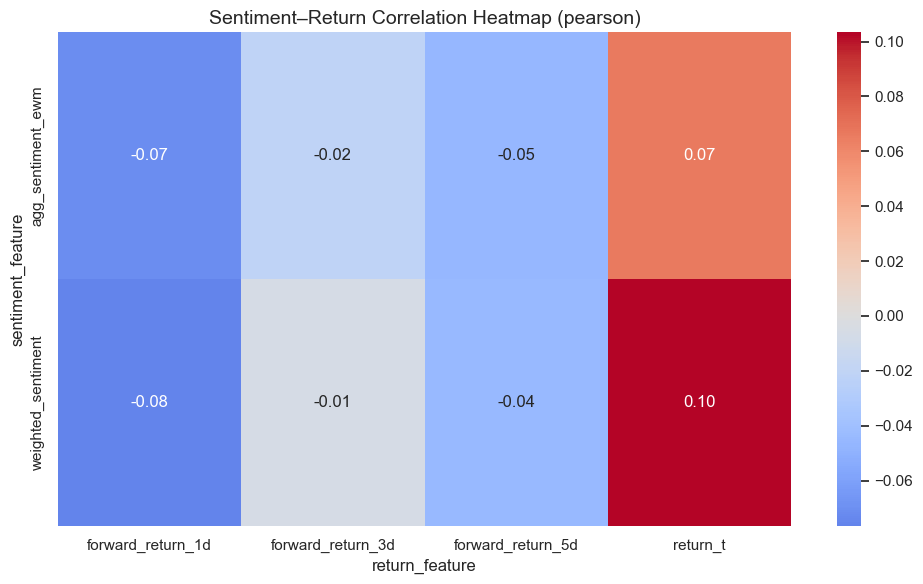

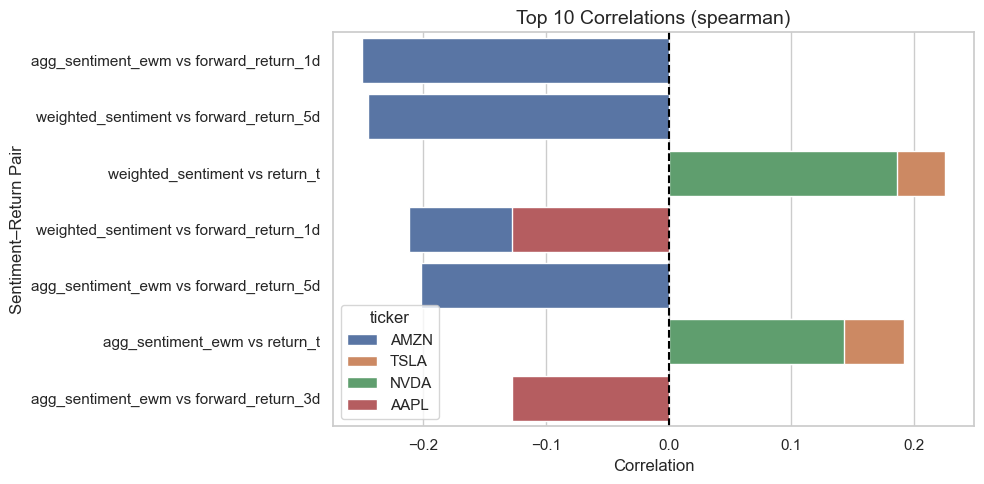

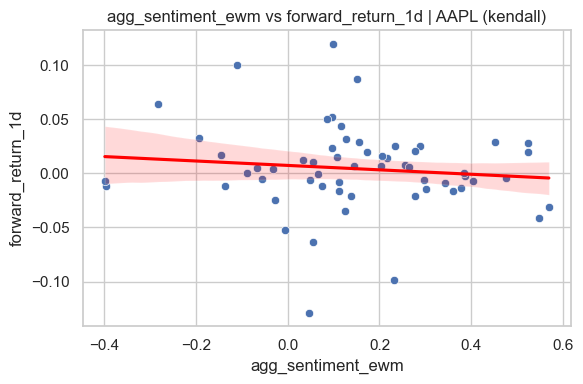

In [9]:
# ------------------------------------------------------------------------------
# 📈 Visualize Correlation Results using CorrelationVisualizer (Task 3)
# ------------------------------------------------------------------------------

import pandas as pd  # for DataFrame handling
from src.correlation_visualizer import CorrelationVisualizer  # ✅ Task 3 visual engine

try:
    # 1️⃣ Confirm correlation_df and final_df exist
    print("🔍 Correlation DataFrame preview:")
    display(correlation_df.head(3))
    print("📦 Shape:", correlation_df.shape)

    # 2️⃣ Confirm raw data (final_df) has required columns
    print("🔍 Available columns in raw_df (final_df):")
    print(final_df.columns.tolist())

    # 3️⃣ Initialize visualizer with both correlation and raw data
    visualizer = CorrelationVisualizer(
        correlation_df=correlation_df, raw_df=final_df, verbose=True
    )

    # 4️⃣ Plot method-specific heatmap
    visualizer.plot_heatmap(method="pearson", figsize=(10, 6))

    # 5️⃣ Plot top-N strongest correlations
    visualizer.plot_top_correlations(top_n=10, method="spearman")

    # 6️⃣ Plot a scatter diagnostic for a sentiment–return pair
    visualizer.plot_scatter_pairs(
        sentiment_col="agg_sentiment_ewm",
        return_col="forward_return_1d",
        ticker="AAPL",  # Change ticker if needed
        method="kendall",
    )

except Exception as e:
    print(f"\n❌ Correlation visualization failed: {type(e).__name__} – {e}")